In [4]:
from mylib.statistic_test import *
from scipy.stats import nbinom, gamma, poisson
from mylib.model import ContinuousHiddenStateModel
code_id = '0349 - Simulated Coordination'
loc = join(figpath, code_id)
mkdir(loc)

with open(r"E:\Data\FinalResults\0346 - GLM for all sessions\10227_MA_iter1.pkl", 'rb') as handle:
    models, _ = pickle.load(handle)
    
sfer_model: ContinuousHiddenStateModel = models[-4]

class GammaPoissonModel:
    def __init__(self, n_neuron = 500, alpha = 5.3, beta = 9.4) -> None:
        self.n_neuron = n_neuron
        self.a = alpha
        self.b = beta
        
        self.propensity = gamma.rvs(self.a, scale=1/self.b, size=self.n_neuron)
        self.field_num = self.generate_field_num()
            
    def get_field_num_sum(self):
        return int(np.sum(self.field_num))
    
    def generate_field_num(self):
        field_num = np.zeros(self.n_neuron)
        for n in range(self.n_neuron):
            field_num[n] = poisson.rvs(self.propensity[n] * 9)
        return field_num.astype(np.int64)
        
    @staticmethod
    def get_field_num(n_neuron = 500, alpha = 5.3, beta = 9.4) -> 'GammaPoissonModel':
        model = GammaPoissonModel(n_neuron, alpha, beta)
        return model

class SFERCorrection:
    def __init__(
        self, 
        sfer_model: ContinuousHiddenStateModel, 
        n_neuron = 500, 
        n_day = 26,
        is_propensity = True
    ) -> None:
        self.GPM = GammaPoissonModel.get_field_num(n_neuron = n_neuron)
        self.field_num = self.GPM.field_num
        self.SFERM = sfer_model
        self.nn = n_neuron
        self.nd = n_day
        self.propensity = self.GPM.propensity
        self.stability = np.random.normal(0, 0.2, self.nn)
        
    def simulate(self, types = 1):
        field_reg = np.zeros((np.sum(self.field_num), self.nd), np.int64)
        field_reg[:, 0] = 1
        p = np.zeros_like(field_reg, np.float64)
        p[:, 0] = np.repeat(self.SFERM.p0, field_reg.shape[0])
        field_info = np.concatenate([np.repeat(i, self.field_num[i]) for i in range(self.nn)])
        field_pos = np.random.choice(np.arange(1, 2305), np.sum(self.field_num))
        
        is_permanent_silent = np.zeros(field_info.shape[0])
        for i in tqdm(range(1, self.nd)):
            # Corrected P
            
            
            
            if types in [4, 6]:
                stability = self.stability[field_info]
                p[:, i-1] = np.clip((1 - stability) * p[:, i-1] + stability, 1e-8, 1 - 1e-8)
            
            if types in [5, 6]:
                p_temp = np.zeros(p.shape[0])
            
                for j in range(field_reg.shape[0]):
                    idx = np.where(
                        (field_info == field_info[j])&
                        (is_permanent_silent < 8) &
                        (field_reg[:, i-1] == 1)
                    )[0]
                    idx = idx[idx != j]
                
                    if idx.shape[0] > 0:
                        p_temp[j] = (1 - 0.2) * p[j, i-1] + 0.2 * np.mean(p[idx, i-1])
                p[:, i-1] = p_temp
            
            if types in [2, 3, 6]:
                # Day-to-day fluctuation
                rand_fluc = np.random.normal(0, 0.1, self.nn)
                for j in range(self.nn):
                    idx = np.where((field_info == j)&(field_reg[:, i-1] == 1))[0]
                    if idx.shape[0] > 0:
                        p[idx, i-1] = np.clip(p[idx, i-1] + rand_fluc[j], 1e-8, 1-1e-8)
                
            # Generate State
            for j in range(p.shape[0]):
                if is_permanent_silent[j] < 8:
                    field_reg[j, i] = np.random.choice([0, 1], p=[1 - p[j, i-1], p[j, i-1]])
            # Predict p
            p[:, i] = self.SFERM.predict(field_reg[:, i], p[:, i-1])
            
            # Update Field State
            is_permanent_silent[field_reg[:, i] == 0] += 1
            is_permanent_silent[field_reg[:, i] == 1] = 0
            
            # Append new field
            prev_num = np.zeros(self.nn)
            for j in range(self.nn):
                prev_num[j] = np.sum(field_info == j)
                
            p_res = self.calc_field_formation_gradient(prev_num)
            df = np.sum(field_reg[:, i-1]) - np.sum(field_reg[:, i]) 
            if df <= 0:
                continue
            
            if types in [1, 3, 6]:
                n_neuron = np.random.choice(np.arange(self.nn), p=p_res, size=df)
            else:
                n_neuron = np.random.choice(np.arange(self.nn), size=df)
                
            append_reg = np.zeros((df, self.nd), np.int64)
            append_reg[:, i] = 1
            
            field_reg = np.vstack([field_reg, append_reg])
            
            field_info = np.concatenate([field_info, n_neuron])
            field_pos = np.concatenate([field_pos, np.random.choice(np.arange(1, 2305), df)])
            is_permanent_silent = np.concatenate([is_permanent_silent, np.zeros(df)])
            p = np.vstack([p, np.ones((df, self.nd), np.float64) * self.SFERM.p0])
        
        self.field_reg = field_reg
        self.field_info = field_info
        self.field_pos = field_pos
        self.predicted_prob = p
        return field_reg, field_info, field_pos
    
    def calc_field_formation_gradient(self, field_num):
        propensity = self.GPM.propensity
        
        p_res = np.zeros(field_num.shape[0])
        for i in range(field_num.shape[0]):
            p_res[i] = (1 - poisson.cdf(field_num[i], propensity[i] * 9))*propensity[i]
        
        p_res = p_res / np.sum(p_res)
        return p_res
        
    
    def _check_permanent_silent(self, field_reg):
        for i in range(field_reg.shape[0]):
            I = 0
            for j in range(field_reg.shape[1]):
                if field_reg[i, j] == 0:
                    I += 1
                else:
                    I = 0
                
                if I >= 9:
                    field_reg[i, j:] = 0
        
        return field_reg
            
def compute_mats(
    field_reg,
    field_info,
    field_pos
):
    D = GetDMatrices(1, 48)
    sib_field_pairs, non_field_pairs = [], []
    for i in tqdm(range(len(field_info)-1)):
        for j in range(i+1, len(field_info)):
            if field_info[i] == field_info[j]:
                if len(sib_field_pairs) >= 3000000:
                    continue
                if D[int(field_pos[i])-1, int(field_pos[j])-1] <= 50:
                    continue

                sib_field_pairs.append([i, j])
                sib_field_pairs.append([j, i])
            else:
                if len(non_field_pairs) >= 200000000:
                    continue
                non_field_pairs.append([i, j])
                non_field_pairs.append([j, i])
                
    sib_field_pairs = np.array(sib_field_pairs)
    non_field_pairs = np.array(non_field_pairs)
    
    session, mat = compute_joint_probability_matrix(
            field_reg.astype(np.float64).T,
            field_info,
            dim=2,
            return_item='sib',
            field_centers=field_pos,
            sib_field_pairs=sib_field_pairs,
            non_field_pairs=non_field_pairs
    )
    session, mat2 = compute_joint_probability_matrix(
            field_reg.astype(np.float64).T,
            field_info,
            dim=2,
            return_item='non',
            field_centers=field_pos,
            sib_field_pairs=sib_field_pairs,
            non_field_pairs=non_field_pairs
    )
    return mat, mat2

def compute_across_models(
    sfer_model: ContinuousHiddenStateModel
):
    res = {
        "X": [],
        "Pair Type": [],
        "delta-P": [],
        "Model Type": []
    }
    
    # Pure Drift
    field_reg = sfer_model.simulate_across_day(n_step=26, n_fields=2500)[0]
    field_info = np.random.choice(np.arange(500), size=field_reg.shape[0], replace=True)
    field_centers = np.random.choice(np.arange(1, 2305), size = field_reg.shape[0])
    mat1, mat2 = compute_mats(field_reg, field_info, field_centers)
    x = np.concatenate([np.repeat(1, 25), np.repeat(2, 25), np.repeat(3, 25)])
    y1 = np.concatenate([mat1[:, 0, 0], mat1[:, 1, 1], mat1[:, 2, 2]])
    y2 = np.concatenate([mat2[:, 0, 0], mat2[:, 1, 1], mat2[:, 2, 2]])
    pt = np.concatenate([np.repeat('sib', 75), np.repeat('non', 75)])
    res["X"].append(np.concatenate([x, x]))
    res["delta-P"].append(np.concatenate([y1, y2]))
    res["Pair Type"].append(pt)
    res["Model Type"].append(np.repeat('Pure Drift', pt.shape[0]))
    
    # SFER Based
    for types in range(1, 6):
        SFER = SFERCorrection(sfer_model, 500, n_day=26)
        SFER.simulate(types=types)
        mat1, mat2 = compute_mats(SFER.field_reg, SFER.field_info, SFER.field_pos)
        x = np.concatenate([np.repeat(1, 25), np.repeat(2, 25), np.repeat(3, 25)])
        y1 = np.concatenate([mat1[:, 0, 0], mat1[:, 1, 1], mat1[:, 2, 2]])
        y2 = np.concatenate([mat2[:, 0, 0], mat2[:, 1, 1], mat2[:, 2, 2]])
        pt = np.concatenate([np.repeat('sib', 75), np.repeat('non', 75)])
        res["X"].append(np.concatenate([x, x]))
        res["delta-P"].append(np.concatenate([y1, y2]))
        res["Pair Type"].append(pt)
        res["Model Type"].append(np.repeat(f'SFER Corrected {types}', pt.shape[0]))
    
    for k in res.keys():
        res[k] = np.concatenate(res[k])
    
    return res

if exists(join(figdata, code_id+".pkl")):
    with open(join(figdata, code_id+".pkl"), 'rb') as f:
        Data = pickle.load(f)
else:
    Data = {
        "X": [],
        "Pair Type": [],
        "delta-P": [],
        "Model Type": []
    }
    
    with open(r"E:\Data\FinalResults\0346 - GLM for all sessions\10227_MA_iter1.pkl", 'rb') as handle:
        models, _ = pickle.load(handle)
    
    sfer_model: ContinuousHiddenStateModel = models[-4]    

    for i in range(5):
        print(f"Iteration {i}")
        res = compute_across_models(sfer_model)
        for k in res.keys():
            Data[k].append(res[k])
        print("\n\n")
    
    for i in range(len(f_CellReg_modi)):
        break
        if f_CellReg_modi['Type'][i] != 'Real' or f_CellReg_modi['maze_type'][i] == 0:
            continue
    
        mouse = int(f_CellReg_modi['MiceID'][i])
        if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
            continue
            paradigm = "MA" if int(f_CellReg_modi['maze_type'][i]) == 1 else "MB"
            print(mouse, paradigm)
            with open(join(figpath, '0346 - GLM for all sessions', f"{mouse}_{paradigm}_iter1.pkl"), 'rb') as f:
                models1, models2 = pickle.load(f)
            
            sfer_model: ContinuousHiddenStateModel = models1[-4]
            
            res = compute_across_models(sfer_model)
            for k in res.keys():
                Data[k].append(res[k])
            Data['MiceID'].append(np.repeat(mouse, res['X'].shape[0]))
            Data['Paradigm'].append(np.repeat(paradigm, res['X'].shape[0]))
        else:
            continue
            for dirs in ['cis', 'trs']:
                if f_CellReg_modi['paradigm'][i] == "Reverse":
                    paradigm = "MAf" if dirs == 'cis' else "MAb"
                else:
                    paradigm = "HPf" if dirs == 'cis' else "HPb"
                
                with open(join(figpath, '0346 - GLM for all sessions', f"{mouse}_{paradigm}_iter1.pkl"), 'rb') as f:
                    models = pickle.load(f)
                sfer_model: ContinuousHiddenStateModel = models[-4]    
                res = compute_across_models(sfer_model)
                for k in res.keys():
                    Data[k].append(res[k])
                Data['MiceID'].append(np.repeat(mouse, res['X'].shape[0]))
                Data['Paradigm'].append(np.repeat(paradigm, res['X'].shape[0]))
        
        print("\n\n")
        
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    with open(join(figdata, code_id+".pkl"), 'wb') as f:    
        pickle.dump(Data, f)

    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id+".xlsx"), index=False)      
    
    
"""   
if __name__ == '__main__':
    n_neuron = 500
    alpha = 10
    beta = 8.5
    sfer_model: ContinuousHiddenStateModel = models[-4]
    #field_reg = sfer_model.simulate_across_day(n_step=26, n_fields=2500)[0]
    SFER = SFERCorrection(sfer_model, n_neuron, n_day=26)
    field_reg, field_info, field_center = SFER.simulate()
    #print(SFER.field_reg.shape)
    #field_centers = np.random.choice(np.arange(1, 2305), size = SFER.field_reg.shape[0])
""" 

        E:\Data\FinalResults\0349 - Simulated Coordination is already existed!


"   \nif __name__ == '__main__':\n    n_neuron = 500\n    alpha = 10\n    beta = 8.5\n    sfer_model: ContinuousHiddenStateModel = models[-4]\n    #field_reg = sfer_model.simulate_across_day(n_step=26, n_fields=2500)[0]\n    SFER = SFERCorrection(sfer_model, n_neuron, n_day=26)\n    field_reg, field_info, field_center = SFER.simulate()\n    #print(SFER.field_reg.shape)\n    #field_centers = np.random.choice(np.arange(1, 2305), size = SFER.field_reg.shape[0])\n"

# Pure SFER

TtestResult(statistic=-1.6449829164334988, pvalue=0.1025060571428144, df=124)
TtestResult(statistic=1.471646924987861, pvalue=0.14364963319416188, df=124)
   TtestResult(statistic=-2.175933750038501, pvalue=0.031456172769141685, df=124)

TtestResult(statistic=-0.314893026111247, pvalue=0.7533721408573265, df=124)
TtestResult(statistic=-0.9218844588235638, pvalue=0.35837904558622624, df=124)
   TtestResult(statistic=0.2566272423759901, pvalue=0.7978918425963757, df=124)

TtestResult(statistic=1.1197763781358885, pvalue=0.26497333988175764, df=124)
TtestResult(statistic=-1.9139706349445247, pvalue=0.0579284519365564, df=124)
   TtestResult(statistic=2.117286566477988, pvalue=0.03623307466327636, df=124)



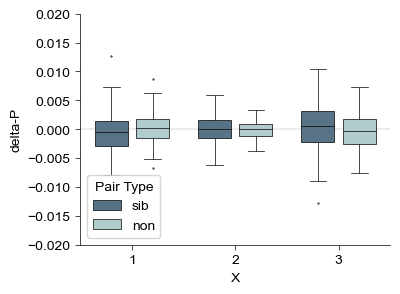

In [12]:
idx = np.where(Data['Model Type'] == 'Pure Drift')[0]
SubData = SubDict(Data, Data.keys(), idx)
fig = plt.figure(figsize=(4,3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', linestyle='--', linewidth=0.15)
sns.boxplot(
    x = 'X',
    y = 'delta-P',
    hue = 'Pair Type',
    palette=['#4F758D', '#ABD0D1'],
    data=SubData,
    ax = ax,
    linecolor='black',
    linewidth=0.5,
    gap=0.2,
    flierprops={'markersize': 0.5},
)
ax.set_ylim([-0.02, 0.02])
plt.savefig(join(loc, "Pure SFER.png"), dpi=600)
plt.savefig(join(loc, "Pure SFER.svg"), dpi=600)

for x in np.arange(1, 4):
    idx1 = np.where((SubData['X'] == x)&(SubData['Pair Type'] == 'sib'))[0]
    idx2 = np.where((SubData['X'] == x)&(SubData['Pair Type'] == 'non'))[0]
    
    print(ttest_1samp(SubData['delta-P'][idx1], 0))
    print(ttest_1samp(SubData['delta-P'][idx2], 0))
    print("  ",ttest_rel(SubData['delta-P'][idx1], SubData['delta-P'][idx2]))
    print()
    

# SFER with Propensity

TtestResult(statistic=6.455953646079455, pvalue=2.1969280421662063e-09, df=124)
TtestResult(statistic=-0.1880488248182988, pvalue=0.851145766691634, df=124)
TtestResult(statistic=6.109579873970024, pvalue=1.1904723362529009e-08, df=124)

TtestResult(statistic=9.997698855306597, pvalue=1.2813130787905987e-17, df=124)
TtestResult(statistic=0.9704799283159364, pvalue=0.3336965364014113, df=124)
TtestResult(statistic=9.784093750500848, pvalue=4.222876027840159e-17, df=124)

TtestResult(statistic=2.441026135641795, pvalue=0.01605772088543543, df=124)
TtestResult(statistic=-0.01615544612900484, pvalue=0.9871363448480441, df=124)
TtestResult(statistic=1.997893445218141, pvalue=0.047916498582047766, df=124)



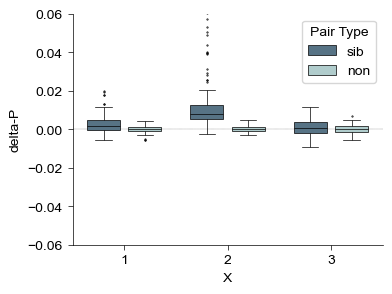

In [13]:
idx = np.where(Data['Model Type'] == 'SFER Corrected 1')[0]
SubData = SubDict(Data, Data.keys(), idx)
fig = plt.figure(figsize=(4,3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', linestyle='--', linewidth=0.15)
sns.boxplot(
    x = 'X',
    y = 'delta-P',
    hue = 'Pair Type',
    palette=['#4F758D', '#ABD0D1'],
    data=SubData,
    ax = ax,
    linecolor='black',
    linewidth=0.5,
    gap=0.2,
    flierprops={'markersize': 0.5},
)
ax.set_ylim([-0.06, 0.06])
plt.savefig(join(loc, "SFER + Propensity.png"), dpi=600)
plt.savefig(join(loc, "SFER + Propensity.svg"), dpi=600)

for x in np.arange(1, 4):
    idx1 = np.where((SubData['X'] == x)&(SubData['Pair Type'] == 'sib'))[0]
    idx2 = np.where((SubData['X'] == x)&(SubData['Pair Type'] == 'non'))[0]
    
    print(ttest_1samp(SubData['delta-P'][idx1], 0))
    print(ttest_1samp(SubData['delta-P'][idx2], 0))
    print(ttest_rel(SubData['delta-P'][idx1], SubData['delta-P'][idx2]))
    print()
    

# SFER with fluctuation

TtestResult(statistic=9.267260563319237, pvalue=7.468157123241786e-16, df=124)
TtestResult(statistic=-2.335160036032085, pvalue=0.02114163121798897, df=124)
TtestResult(statistic=9.315838709137065, pvalue=5.706353275012933e-16, df=124)

TtestResult(statistic=-9.485387233708202, pvalue=2.2273605334331155e-16, df=124)
TtestResult(statistic=0.4641323345200098, pvalue=0.6433667404168404, df=124)
TtestResult(statistic=-8.647818892991495, pvalue=2.2567786733611252e-14, df=124)

TtestResult(statistic=29.474904621244594, pvalue=7.419307549021306e-58, df=124)
TtestResult(statistic=0.6157247368126956, pvalue=0.5392047330373102, df=124)
TtestResult(statistic=27.180330815773104, pvalue=4.509310861524834e-54, df=124)



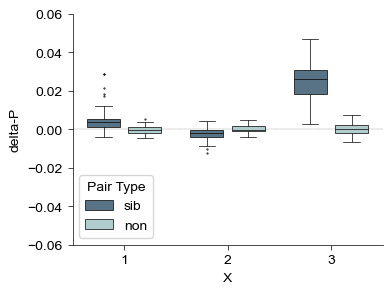

In [11]:
idx = np.where(Data['Model Type'] == 'SFER Corrected 2')[0]
SubData = SubDict(Data, Data.keys(), idx)
fig = plt.figure(figsize=(4,3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', linestyle='--', linewidth=0.15)
sns.boxplot(
    x = 'X',
    y = 'delta-P',
    hue = 'Pair Type',
    palette=['#4F758D', '#ABD0D1'],
    data=SubData,
    ax = ax,
    linecolor='black',
    linewidth=0.5,
    gap=0.2,
    flierprops={'markersize': 0.5},
)
ax.set_ylim([-0.06, 0.06])
plt.savefig(join(loc, "SFER + Fluctuation.png"), dpi=600)
plt.savefig(join(loc, "SFER + Fluctuation.svg"), dpi=600)

for x in np.arange(1, 4):
    idx1 = np.where((SubData['X'] == x)&(SubData['Pair Type'] == 'sib'))[0]
    idx2 = np.where((SubData['X'] == x)&(SubData['Pair Type'] == 'non'))[0]
    
    print(ttest_1samp(SubData['delta-P'][idx1], 0))
    print(ttest_1samp(SubData['delta-P'][idx2], 0))
    print(ttest_rel(SubData['delta-P'][idx1], SubData['delta-P'][idx2]))
    print()

# SFER + Both

In [ ]:
idx = np.where(Data['Model Type'] == 'SFER Corrected 3')[0]
SubData = SubDict(Data, Data.keys(), idx)
fig = plt.figure(figsize=(4,3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', linestyle='--', linewidth=0.15)
sns.boxplot(
    x = 'X',
    y = 'delta-P',
    hue = 'Pair Type',
    palette=['#4F758D', '#ABD0D1'],
    data=SubData,
    ax = ax,
    linecolor='black',
    linewidth=0.5,
    gap=0.2,
    flierprops={'markersize': 0.5},
)
ax.set_ylim([-0.06, 0.06])
plt.savefig(join(loc, "SFER + Both.png"), dpi=600)
plt.savefig(join(loc, "SFER + Both.svg"), dpi=600)

for x in np.arange(1, 4):
    idx1 = np.where((SubData['X'] == x)&(SubData['Pair Type'] == 'sib'))[0]
    idx2 = np.where((SubData['X'] == x)&(SubData['Pair Type'] == 'non'))[0]
    
    print(ttest_1samp(SubData['delta-P'][idx1], 0))
    print(ttest_1samp(SubData['delta-P'][idx2], 0))
    print(ttest_rel(SubData['delta-P'][idx1], SubData['delta-P'][idx2]))
    print()